# Hurricane Data Project

### Project Description

The goal of this project is to use the HURDAT2 data to determine the hurricanes that have made landfall in Florida since 1900. We will output a report which indicates the max wind speed of this storm, along with the first date of landfall. We will use the hurdat2 data from https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt, and we will get geographical data from https://eric.clst.org/tech/usgeojson/. 

First, we will specify the project question. Landfall is defined as the event of a storm moving over land after being over water. This means that a storm can make multiple landfalls. This means that there is some ambiguity in the project question. There is a strict requirement and a liberal requirement as follows:

Strict requirement:
- The storm makes landfall in Florida
- The storm is a hurricane while it is making landfall in Florida
- The date on the data is the date of the first landfall in Florida while the storm is a hurricane
- The wind speed on the data is the max wind speed while making the first landfall in Florida while the storm is a hurricane

Liberal requirement:
- The storm makes landfall in Florida
- The storm reaches hurricane status at some point
- The date on the data is the date of the first landfall in Florida
- The wind speed on the data is the max wind speed of the storm

Additionally, the hurdat2 data gives latitude/longitude coordinates for hurricanes over time. We will assume that the hurricanes travel in straight lines between the points. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import requests
import geopandas as gpd
from shapely.geometry import LineString

<Axes: >

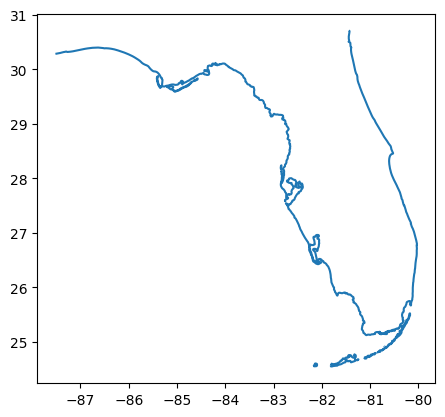

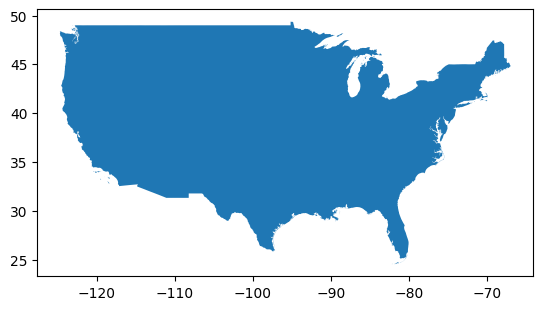

In [2]:
gdf = gpd.read_file('gz_2010_us_outline_500k.json') # https://eric.clst.org/tech/usgeojson/
x1 = gdf.geometry.apply(lambda geom: geom.coords[0][0])
y1 = gdf.geometry.apply(lambda geom: geom.coords[0][1])
x2 = gdf.geometry.apply(lambda geom: geom.coords[1][0])
y2 = gdf.geometry.apply(lambda geom: geom.coords[1][1])

in_range = ((-130 < x1) & (x1 < -50)) & ((24 < y1) & (y1 < 50))
mainland = gdf[in_range]
us_area = mainland.build_area()

in_range = ((-87.4 < x1) & (x1 < -79)) & ((24 < y1) & (y1 < 30.71))
florida_coast = gdf[in_range]

florida_coast.plot()
us_area.plot()

In [3]:
url = "https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2024-040425.txt"
text = requests.get(url).text
lines = pd.Series(text.split('\n')[:-1]).str.replace(' ','')
is_header = lines.str.startswith('AL')

linedf = pd.DataFrame({'raw_line':lines,'is_header':is_header})
linedf['storm_id'] = np.where(linedf['is_header'],linedf['raw_line'].str.split(',').str[0],np.nan)
linedf['storm_id']=linedf['storm_id'].ffill()

dfh = lines[is_header].str.split(',',n=2,expand = True)
dfh = dfh.rename(columns={0: 'storm_id', 1: 'storm_name',2:'rows'})
dfh['rows'] = pd.to_numeric(dfh['rows'].str.replace(',',''))
dfh=dfh.set_index('storm_id',drop=True)

dfm = linedf[is_header == False]
dfm = pd.concat([dfm,dfm['raw_line'].str.split(',',expand = True)],axis=1)
dfm = dfm.rename(columns={
    0: 'date', 1: 'hours', 2:'landfall_marker', 3:'status', 4:'latitude_N', 5:'longitude_E_old', 6:'wind_speed', 7: 'pressure'
})
dfm = dfm.drop(range(8,21),axis=1)
dfm['is_hurricane'] = dfm['status'] == 'HU'
cols_to_convert = ['wind_speed','pressure']
dfm[cols_to_convert] = dfm[cols_to_convert].apply(pd.to_numeric, errors='coerce')
dfm['datetime'] = pd.to_datetime(
    dfm['date'] + dfm['hours'],
    format='%Y%m%d%H%M'
)
dfm['latitude_N'] = pd.to_numeric(dfm['latitude_N'].str[:-1])
dfm['longitude_E'] = pd.to_numeric(dfm['longitude_E_old'].str[:-1])
dfm['longitude_E'] = np.where(dfm['longitude_E_old'].str[-1] == 'E',dfm['longitude_E'],dfm['longitude_E']*-1)
dfm = dfm.drop(['longitude_E_old','raw_line'],axis=1)
dfm = gpd.GeoDataFrame(dfm,geometry = gpd.points_from_xy(dfm['longitude_E'], dfm['latitude_N']),crs = us_area.crs)
dfm['on_land'] = dfm.within(us_area.union_all())


dfh['reaches_hurricane'] = dfm.groupby('storm_id')['is_hurricane'].any()

In [4]:
dfl = dfm[['storm_id', 'geometry','on_land','datetime','wind_speed','is_hurricane']].copy()
dfl = dfl.rename(columns={'on_land': 'starts_on_land'})
dfl['shifted_geo'] = dfl['geometry'].shift(-1)
dfl['shifted_storm_id'] = dfl['storm_id'].shift(-1)
dfl = dfl[dfl['shifted_storm_id'] == dfl['storm_id']]
new_lines_list = [LineString([start, end]) for start, end in zip(dfl['geometry'], dfl['shifted_geo'])]
dfl = dfl.drop(columns=['shifted_geo','geometry','shifted_storm_id'])
dfl = gpd.GeoDataFrame(dfl, geometry=new_lines_list)
dfl

,storm_id,starts_on_land,datetime,wind_speed,is_hurricane,geometry
1,AL011851,False,1851-06-25 00:00:00,80,True,"LINESTRING (-94.8 28, -95.4 28)"
2,AL011851,False,1851-06-25 06:00:00,80,True,"LINESTRING (-95.4 28, -96 28)"
3,AL011851,False,1851-06-25 12:00:00,80,True,"LINESTRING (-96 28, -96.5 28.1)"
4,AL011851,False,1851-06-25 18:00:00,80,True,"LINESTRING (-96.5 28.1, -96.8 28.2)"
5,AL011851,False,1851-06-25 21:00:00,80,True,"LINESTRING (-96.8 28.2, -97 28.2)"
...,...,...,...,...,...,...
57215,AL192024,False,2024-11-17 00:00:00,35,False,"LINESTRING (-87.1 16.4, -87.5 16.5)"
57216,AL192024,False,2024-11-17 06:00:00,35,False,"LINESTRING (-87.5 16.5, -87.9 16.8)"
57217,AL192024,False,2024-11-17 12:00:00,35,False,"LINESTRING (-87.9 16.8, -88.3 17)"
57218,AL192024,False,2024-11-17 14:00:00,35,False,"LINESTRING (-88.3 17, -89.1 17.4)"


C:\Users\benjr\AppData\Local\Temp\ipykernel_26080\780589209.py:30: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfl = dfm.groupby(by='storm_id', group_keys=False).apply(create_lines)
C:\Users\benjr\AppData\Local\Temp\ipykernel_26080\780589209.py:35: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dfl['crosses'] = dfl.crosses(florida_coast.unary_union)


GeoDataFrame of storm line segments:
    storm_id  starts_on_land            datetime  wind_speed  is_hurricane  \
0   AL011851           False 1851-06-25 00:00:00          80          True   
1   AL011851           False 1851-06-25 06:00:00          80          True   
2   AL011851           False 1851-06-25 12:00:00          80          True   
3   AL011851           False 1851-06-25 18:00:00          80          True   
4   AL011851           False 1851-06-25 21:00:00          80          True   
..       ...             ...                 ...         ...           ...   
20  AL312020           False 2020-11-17 06:00:00         110          True   
21  AL312020           False 2020-11-17 12:00:00          75          True   
22  AL312020           False 2020-11-17 18:00:00          55         False   
23  AL312020           False 2020-11-18 00:00:00          40         False   
24  AL312020           False 2020-11-18 06:00:00          35         False   

                          

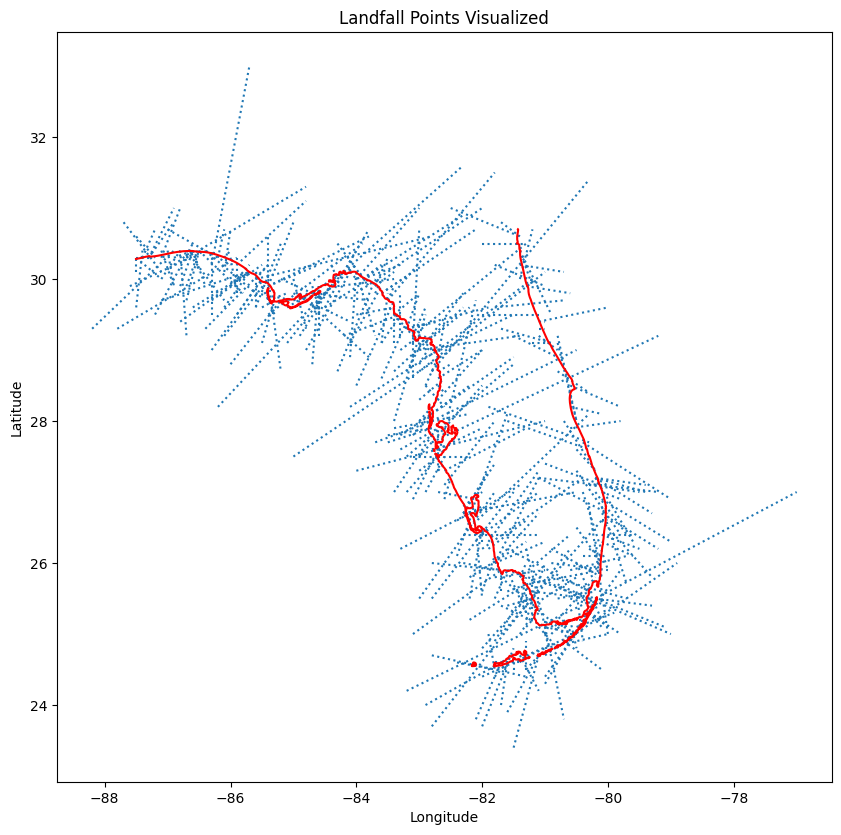

In [5]:
def create_lines(prev_df):
    """
    Creates a GeoDataFrame of LineString segments from a DataFrame of storm points.
    
    Args:
        prev_df (gpd.GeoDataFrame): A GeoDataFrame containing points of a single storm.
        
    Returns:
        gpd.GeoDataFrame: A GeoDataFrame where each row is a line segment.
    """
    # Create a copy and rename for clarity, explicitly including 'storm_id'
    df = prev_df[['storm_id', 'geometry','on_land','datetime','wind_speed','is_hurricane']].copy()
    df = df.rename(columns={'on_land': 'starts_on_land'})
    
    # Create a shifted column to represent the end point of each line segment
    df['shifted_geo'] = df['geometry'].shift(-1)
    
    # Drop the last row, which will have a NaN for the shifted point
    df = df.iloc[:-1]
    
    # Create a list of LineString objects from the start and end points
    new_lines_list = [LineString([start, end]) for start, end in zip(df['geometry'], df['shifted_geo'])]
    
    # Drop the original geometry columns and create a new GeoDataFrame
    df = df.drop(columns=['shifted_geo','geometry'])
    return gpd.GeoDataFrame(df, geometry=new_lines_list).reset_index(drop=True)

# --- Apply the function to each storm_id group to create the line segments ---
# The `.apply` method is used correctly here for a complex, group-wise operation.
dfl = dfm.groupby(by='storm_id', group_keys=False).apply(create_lines)
#dfl = dfl.reset_index(names=['storm_id', 'order_in_storm'])

# --- Perform the spatial and logical operations on the new lines ---
# The `.crosses` method checks for intersections between the lines and the coast
dfl['crosses'] = dfl.crosses(florida_coast.unary_union)

# A landfall occurs when a storm segment crosses the coast and starts over water
dfl['landfall'] = (dfl['starts_on_land'] == False) & dfl['crosses']

# --- Plot the results to visualize the landfall points ---
fig, ax = plt.subplots(figsize=(10, 10))
dfl[dfl['landfall']].plot(linestyle='dotted', ax=ax)
florida_coast.plot(color='red', ax=ax)
plt.title("Landfall Points Visualized")
plt.xlabel("Longitude")
plt.ylabel("Latitude")

# --- Display the resulting GeoDataFrame ---
print("GeoDataFrame of storm line segments:")
print(dfl)

C:\Users\benjr\AppData\Local\Temp\ipykernel_26080\670824471.py:13: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  dfl = dfm.groupby(by='storm_id').apply(create_lines).reset_index(names=['storm_id','order_in_storm'])
C:\Users\benjr\AppData\Local\Temp\ipykernel_26080\670824471.py:14: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  dfl['crosses'] = dfl.crosses(florida_coast.unary_union)


,storm_id,order_in_storm,starts_on_land,datetime,wind_speed,is_hurricane,geometry,crosses,landfall
0,AL011851,0,False,1851-06-25 00:00:00,80,True,"LINESTRING (-94.8 28, -95.4 28)",False,False
1,AL011851,1,False,1851-06-25 06:00:00,80,True,"LINESTRING (-95.4 28, -96 28)",False,False
2,AL011851,2,False,1851-06-25 12:00:00,80,True,"LINESTRING (-96 28, -96.5 28.1)",False,False
3,AL011851,3,False,1851-06-25 18:00:00,80,True,"LINESTRING (-96.5 28.1, -96.8 28.2)",False,False
4,AL011851,4,False,1851-06-25 21:00:00,80,True,"LINESTRING (-96.8 28.2, -97 28.2)",False,False
...,...,...,...,...,...,...,...,...,...
53234,AL312020,20,False,2020-11-17 06:00:00,110,True,"LINESTRING (-83.8 13.7, -84.7 13.7)",False,False
53235,AL312020,21,False,2020-11-17 12:00:00,75,True,"LINESTRING (-84.7 13.7, -85.7 13.7)",False,False
53236,AL312020,22,False,2020-11-17 18:00:00,55,False,"LINESTRING (-85.7 13.7, -86.7 13.8)",False,False
53237,AL312020,23,False,2020-11-18 00:00:00,40,False,"LINESTRING (-86.7 13.8, -87.8 13.8)",False,False


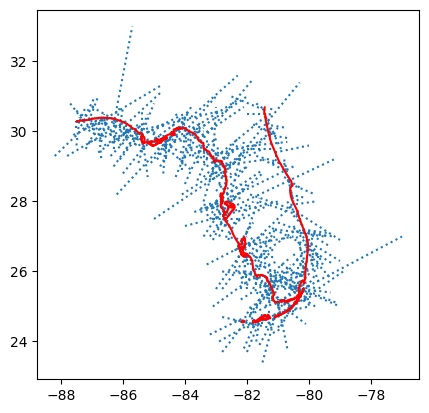

In [6]:
def create_lines(prev_df):

    df = prev_df[['geometry','on_land','datetime','wind_speed','is_hurricane']].copy()
    df=df.rename(columns={'on_land': 'starts_on_land'})
    
    df['shifted_geo'] = df['geometry'].shift(-1)
    # Drop the first row which will have a NaN for the previous point
    df = df.iloc[:-1]
    new_lines_list = [LineString([start, end]) for start, end in zip(df['geometry'], df['shifted_geo'])]
    df = df.drop(columns=['shifted_geo','geometry'])
    return gpd.GeoDataFrame(df, geometry = new_lines_list).reset_index(drop=True)

dfl = dfm.groupby(by='storm_id').apply(create_lines).reset_index(names=['storm_id','order_in_storm'])
dfl['crosses'] = dfl.crosses(florida_coast.unary_union)
dfl['landfall'] = (dfl['starts_on_land'] == False) & dfl['crosses']

fig,ax=plt.subplots()
dfl[dfl['landfall']].plot(linestyle='dotted',ax=ax)
florida_coast.plot(color='red',ax=ax)

dfl

In [7]:
def analyze_storm(df_in):
    df = df_in[df_in['landfall'] ==True][['datetime','geometry','storm_id','wind_speed']].copy()
    df.rename(columns={'wind_speed':'wind_speed_at_first_landfall'})
    df['max_wind_speed'] = df['wind_speed'].max()
    return df.loc[df['datetime'] == df['datetime'].min()]

landfall_events = dfl.groupby(by='storm_id').apply(analyze_storm).set_index('storm_id',drop = True)
valid_storm_df = pd.concat([dfh,landfall_events],join = 'inner',axis=1)
valid_storm_df = valid_storm_df[valid_hurricane_df['datetime'].dt.year>=1900]
valid_storm_df

C:\Users\benjr\AppData\Local\Temp\ipykernel_26080\2679549259.py:7: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  landfall_events = dfl.groupby(by='storm_id').apply(analyze_storm).set_index('storm_id',drop = True)


NameError: name 'valid_hurricane_df' is not defined

In [ ]:
fig,ax = plt.subplots(1,2,figsize=(12,10))

plt.hist2d(dfm['longitude_E'], dfm['latitude_N'], bins=(150, 150),cmap = 'Reds_r') 
#plt.tight_layout()
mainland.plot(ax=ax[1],color='black')
florida_coast.plot(ax=ax[1],color = 'blue')
ax[1].set_xlim([-100,-60])
ax[1].set_ylim([15,50])
ax[1].set_title('Frequency of storms')
ax[1].set_xlabel('Longitude')
ax[1].set_ylabel('Latitude')

def plot_storm(storm_id,ax):
    line_data = dfl[dfl['storm_id'] == storm_id]
    point_data = dfm[dfm['storm_id'] == storm_id]
    line_data.plot(ax=ax)

    landfall_lines = line_data[line_data['landfall']]
    landfall_lines.plot(ax=ax,color='red')
    
    point_data.plot(ax=ax)
    florida_coast.plot(ax=ax)
    ax.set_title(f'Path of storm {storm_id}')
    ax.set_xlim([-88,-77])
    ax.set_ylim([22,31])
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')



plot_storm('AL041851',ax[0])

In [ ]:
valid_storms = valid_storm_df.index
valid_storm_points = dfm[dfm['storm_id'].isin(valid_hurricanes)]
valid_storm_points = valid_storm_points.reset_index(drop = True)
valid_storm_lines = dfl[dfl['storm_id'].isin(valid_hurricanes)]
valid_storm_lines = valid_storm_lines.reset_index(drop = True)

valid_storm_df

In [ ]:
#valid_storm_df.to_csv('valid_storm_df.csv')
#valid_storm_points.to_csv('valid_storm_points.csv')
#valid_storm_lines.to_csv('valid_storm_lines.csv')